# Loading and Preprocessing Data

In this chapter, we will cover the Data API, the TFRecord format, and how to create custom preprocessing layers and use the standard Keras ones. We will also take a quick look at a few related projects from TensorFlow’s ecosystem:

* **TF Transform (tf.Transform)** <br>
Makes it possible to write a single preprocessing function that can be run in batch mode on your full training set, before training (to speed it up), and then exported to a TF Function and incorporated into your trained model so that once it is deployed in production it can take care of preprocessing new instances on the fly.

* **TF Datasets (TFDS)** <br>
Provides a convenient function to download many common datasets of all kinds, including large ones like ImageNet, as well as convenient dataset objects to manipulate them using the Data API.

In [ ]:
!pip3 install -U tensorflow-transform

In [1]:
import tensorflow as tf

## The Data API
The whole Data API revolves around the concept of a dataset: representing a sequence of data items.

In [2]:
X = tf.range(10)
print(f"X - {X}")
dataset = tf.data.Dataset.from_tensor_slices(X)
print(f"Dataset - {dataset}")

X - [0 1 2 3 4 5 6 7 8 9]
Dataset - <TensorSliceDataset shapes: (), types: tf.int32>


The from_tensor_slices() function takes a tensor and creates a tf.data.Dataset whose elements are all the slices of X (along the first dimension), so this dataset contains 10 items: tensors 0, 1, 2, …, 9. In this case we would have obtained the same dataset if we had used **tf.data.Dataset.range(10)**.

In [3]:
for item in dataset:
    print(item)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)


### Chaining Transformations
Once you have a dataset, you can apply all sorts of transformations to it by calling its transformation methods. Each method returns a new dataset, so you can chain transformations like this.

In [4]:
dataset = dataset.repeat(3).batch(7)
for item in dataset:
    print(item)

tf.Tensor([0 1 2 3 4 5 6], shape=(7,), dtype=int32)
tf.Tensor([7 8 9 0 1 2 3], shape=(7,), dtype=int32)
tf.Tensor([4 5 6 7 8 9 0], shape=(7,), dtype=int32)
tf.Tensor([1 2 3 4 5 6 7], shape=(7,), dtype=int32)
tf.Tensor([8 9], shape=(2,), dtype=int32)


In this example, we first call the repeat() method on the original dataset, and it returns a new dataset that will repeat the items of the original dataset three times. Of course, this will not copy all the data in memory three times! (If you call this method with no arguments, the new dataset will repeat the source dataset forever, so the code that iterates over the dataset will have to decide when to stop.) Then we call the batch() method on this new dataset, and again this creates a new dataset. This one will group the items of the previous dataset in batches of seven items. Finally, we iterate over the items of this final dataset. As you can see, the batch() method had to output a final batch of size two instead of seven, but you can call it with drop_remain der=True if you want it to drop this final batch so that all batches have the exact same size.

In [5]:
# using map to transform dataset
dataset = dataset.map(lambda x:x*2)
for item in dataset:
    print(item)

tf.Tensor([ 0  2  4  6  8 10 12], shape=(7,), dtype=int32)
tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int32)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int32)
tf.Tensor([ 2  4  6  8 10 12 14], shape=(7,), dtype=int32)
tf.Tensor([16 18], shape=(2,), dtype=int32)


While the map() method applies a transformation to each item, the apply() method applies a transformation to the dataset as a whole. For example, the following code applies the unbatch() function to the dataset (this function is currently experimental, but it will most likely move to the core API in a future release). Each item in the new dataset will be a single-integer tensor instead of a batch of seven integers:

In [6]:
#dataset = dataset.apply(tf.data.experimental.unbatch()) # Now deprecateddataset2 = dataset.unbatch()
for item in dataset2:
    print(item)

NameError: ignored

In [ ]:
# filter dataset
dataset2 = dataset2.filter(lambda x: x < 10)
for ele in dataset2:
    print(ele)

In [ ]:
# check few entries of dataset
for ele in dataset2.take(6):
    print(ele)

### Shuffling Data
A simple way to shuffle the instances is using the shuffle() method. It will create a new dataset that will start by filling up a buffer with the first items of the source dataset. Then, whenever it is asked for an item, it will pull one out randomly from the buffer and replace it with a fresh one from the source dataset, until it has iterated entirely through the source dataset. At this point it continues to pull out items randomly from the buffer until it is empty. You must specify the buffer size, and it is important to make it large enough, or else shuffling will not be very effective. Just don’t exceed the amount of RAM you have, and even if you have plenty of it, there’s no need to go beyond the dataset’s size. You can provide a random seed if you want the same random order every time you run your program. For example, the following code creates and displays a dataset containing the integers 0 to 9, repeated 3 times, shuffled using a buffer of size 5 and a random seed of 42, and batched with a batch size of 7

In [7]:
dataset = tf.data.Dataset.range(10).repeat(3) # 0 to 9, three times
dataset = dataset.shuffle(buffer_size=5, seed=42, 
                          reshuffle_each_iteration=False).batch(7)
for item in dataset:
    print(item)

tf.Tensor([2 5 1 7 0 8 9], shape=(7,), dtype=int64)
tf.Tensor([0 4 3 1 5 6 4], shape=(7,), dtype=int64)
tf.Tensor([6 7 2 9 0 3 3], shape=(7,), dtype=int64)
tf.Tensor([2 8 4 6 8 9 7], shape=(7,), dtype=int64)
tf.Tensor([5 1], shape=(2,), dtype=int64)


#### Interleaving lines from multiple files
First we are gonna download california house dataset and split it into multiple files. 

In [8]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, 
                                                              housing.target.reshape(-1, 1), 
                                                              random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, 
                                                      y_train_full, 
                                                      random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)
X_mean = scaler.mean_
X_std = scaler.scale_

For a very large dataset that does not fit in memory, you will typically want to split it into many files first, then have TensorFlow read these files in parallel. To demonstrate this, let's start by splitting the housing dataset and save it to 20 CSV files:

In [9]:
def save_to_multiple_csv_files(data, name_prefix, header=None, n_parts=10):
    housing_dir = os.path.join("datasets", "housing")
    os.makedirs(housing_dir, exist_ok=True)
    path_format = os.path.join(housing_dir, "my_{}_{:02d}.csv")

    filepaths = []
    m = len(data)
    for file_idx, row_indices in enumerate(np.array_split(np.arange(m), n_parts)):
        part_csv = path_format.format(name_prefix, file_idx)
        filepaths.append(part_csv)
        with open(part_csv, "wt", encoding="utf-8") as f:
            if header is not None:
                f.write(header)
                f.write("\n")
            for row_idx in row_indices:
                f.write(",".join([repr(col) for col in data[row_idx]]))
                f.write("\n")
    return filepaths

In [12]:
import numpy as np
import os

train_data = np.c_[X_train, y_train]
valid_data = np.c_[X_valid, y_valid]
test_data = np.c_[X_test, y_test]
header_cols = housing.feature_names + ["MedianHouseValue"]
header = ",".join(header_cols)

train_filepaths = save_to_multiple_csv_files(train_data, "train", header, n_parts=20)
valid_filepaths = save_to_multiple_csv_files(valid_data, "valid", header, n_parts=10)
test_filepaths = save_to_multiple_csv_files(test_data, "test", header, n_parts=10)

In [13]:
# peek at data
import pandas as pd

pd.read_csv(train_filepaths[0]).head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
0,3.5214,15.0,3.049945,1.106548,1447.0,1.605993,37.63,-122.43,1.442
1,5.3275,5.0,6.490060,0.991054,3464.0,3.443340,33.69,-117.39,1.687
2,3.1000,29.0,7.542373,1.591525,1328.0,2.250847,38.44,-122.98,1.621
3,7.1736,12.0,6.289003,0.997442,1054.0,2.695652,33.55,-117.70,2.621
4,2.0549,13.0,5.312457,1.085092,3297.0,2.244384,33.93,-116.93,0.956


In [14]:
with open(train_filepaths[0]) as f:
    for i in range(5):
        print(f.readline(), end="")

MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
3.5214,15.0,3.0499445061043287,1.106548279689234,1447.0,1.6059933407325193,37.63,-122.43,1.442
5.3275,5.0,6.490059642147117,0.9910536779324056,3464.0,3.4433399602385686,33.69,-117.39,1.687
3.1,29.0,7.5423728813559325,1.5915254237288134,1328.0,2.2508474576271187,38.44,-122.98,1.621
7.1736,12.0,6.289002557544757,0.9974424552429667,1054.0,2.6956521739130435,33.55,-117.7,2.621


In [15]:
train_filepaths

['datasets/housing/my_train_00.csv',
 'datasets/housing/my_train_01.csv',
 'datasets/housing/my_train_02.csv',
 'datasets/housing/my_train_03.csv',
 'datasets/housing/my_train_04.csv',
 'datasets/housing/my_train_05.csv',
 'datasets/housing/my_train_06.csv',
 'datasets/housing/my_train_07.csv',
 'datasets/housing/my_train_08.csv',
 'datasets/housing/my_train_09.csv',
 'datasets/housing/my_train_10.csv',
 'datasets/housing/my_train_11.csv',
 'datasets/housing/my_train_12.csv',
 'datasets/housing/my_train_13.csv',
 'datasets/housing/my_train_14.csv',
 'datasets/housing/my_train_15.csv',
 'datasets/housing/my_train_16.csv',
 'datasets/housing/my_train_17.csv',
 'datasets/housing/my_train_18.csv',
 'datasets/housing/my_train_19.csv']

#### Interleaving

In [16]:
# default shuffle=True
filepath_dataset = tf.data.Dataset.list_files(train_filepaths, seed=42)

# shuffled files
for filepath in filepath_dataset:
    print(filepath)

tf.Tensor(b'datasets/housing/my_train_05.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_16.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_01.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_17.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_00.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_14.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_10.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_02.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_12.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_19.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_07.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_09.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_13.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_15.csv', shape=(), dtype=string)
tf.Ten

Next, you can call the interleave() method to read from five files at a time and interleave their lines (skipping the first line of each file, which is the header row, using the skip() method):

In [17]:
n_readers = 5
dataset = filepath_dataset.interleave(lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
                                      cycle_length=n_readers)

The interleave() method will create a dataset that will pull five file paths from the filepath_dataset, and for each one it will call the function you gave it (a lambda in this example) to create a new dataset (in this case a TextLineDataset). To be clear, at this stage there will be seven datasets in all: the filepath dataset, the interleave dataset, and the five TextLineDatasets created internally by the interleave dataset. When we iterate over the interleave dataset, it will cycle through these five TextLineDatasets, reading one line at a time from each until all datasets are out of items. 

In [18]:
for line in dataset.take(5):
    print(line.numpy())

b'4.5909,16.0,5.475877192982456,1.0964912280701755,1357.0,2.9758771929824563,33.63,-117.71,2.418'
b'2.4792,24.0,3.4547038327526134,1.1341463414634145,2251.0,3.921602787456446,34.18,-118.38,2.0'
b'4.2708,45.0,5.121387283236994,0.953757225433526,492.0,2.8439306358381504,37.48,-122.19,2.67'
b'2.1856,41.0,3.7189873417721517,1.0658227848101265,803.0,2.0329113924050635,32.76,-117.12,1.205'
b'4.1812,52.0,5.701388888888889,0.9965277777777778,692.0,2.4027777777777777,33.73,-118.31,3.215'


These are the first rows (ignoring the header row) of five CSV files, chosen randomly. Looks good! But as you can see, these are just byte strings; we need to parse them and scale the data.

### Preprocessing Data


Converting str to tensor.

In [19]:
n_inputs = 8 # X_train.shape[-1]

@tf.function
def preprocess(line):
    defs = [0.] * n_inputs + [tf.constant([], dtype=tf.float32)]
    fields = tf.io.decode_csv(line, record_defaults=defs)
    x = tf.stack(fields[:-1])
    y = tf.stack(fields[-1:])
    return (x - X_mean) / X_std, y

Code Walkthrough - <br>
* First, the code assumes that we have precomputed the mean and standard deviation of each feature in the training set. X_mean and X_std are just 1D tensors (or NumPy arrays) containing eight floats, one per input feature. <br>
* The preprocess() function takes one CSV line and starts by parsing it. For this it uses the tf.io.decode_csv() function, which takes two arguments: the first is the line to parse, and the second is an array containing the default value for each column in the CSV file. This array tells TensorFlow not only the default value for each column, but also the number of columns and their types. In this example, we tell it that all feature columns are floats and that missing values should default to 0, but we provide an empty array of type tf.float32 as the default value for the last column (the target): the array tells TensorFlow that this column contains floats, but that there is no default value, so it will raise an exception if it encounters a missing value.<br>
* The decode_csv() function returns a list of scalar tensors (one per column), but we need to return 1D tensor arrays. So we call tf.stack() on all tensors except for the last one (the target): this will stack these tensors into a 1D array. We then do the same for the target value (this makes it a 1D tensor array with a single value, rather than a scalar tensor).<br>
* Finally, we scale the input features by subtracting the feature means and then dividing by the feature standard deviations, and we return a tuple containing the scaled features and the target.

In [20]:
preprocess(b'4.2083,44.0,5.3232,0.9171,846.0,2.3370,37.47,-122.2,2.782')

(<tf.Tensor: shape=(8,), dtype=float32, numpy=
 array([ 0.16579157,  1.216324  , -0.05204565, -0.39215982, -0.5277444 ,
        -0.2633488 ,  0.8543046 , -1.3072058 ], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([2.782], dtype=float32)>)

### Putting Everything Together
To make the code reusable, let’s put together everything we have discussed so far into a small helper function: it will create and return a dataset that will efficiently load California housing data from multiple CSV files, preprocess it, shuffle it, optionally repeat it, and batch it.

In [21]:
def csv_reader_dataset(filepaths, repeat=1, n_readers=5,
                       n_read_threads=None, shuffle_buffer_size=10000,
                       n_parse_threads=5, batch_size=32):
    dataset = tf.data.Dataset.list_files(filepaths).repeat(repeat)
    dataset = dataset.interleave(
        lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
        cycle_length=n_readers, num_parallel_calls=n_read_threads)
    dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(1) # for prefetching check next section

### Prefetching
By calling prefetch(1) at the end, we are creating a dataset that will do its best to always be one batch ahead. In other words, while our training algorithm is working on one batch, the dataset will already be working in parallel on getting the next batch ready (e.g., reading the data from disk and preprocessing it). This can improve performance dramatically. If we also ensure that loading and preprocessing are multithreaded (by setting num_parallel_calls when calling interleave() and map()), we can exploit multiple cores on the CPU and hopefully make preparing one batch of data shorter than running a training step on the GPU. 

If the dataset is small enough to fit in memory, you can significantly speed up training by using the dataset’s cache() method to cache its content to RAM. You should generally do this after loading and preprocessing the data, but before shuffling,repeating, batching, and prefetching. This way, each instance will only be read and preprocessed once (instead of once per epoch), but the data will still be shuffled differently at each epoch, and the next batch will still be prepared in advance.

### Using the Dataset with tf.keras


Now we can use the csv_reader_dataset() function to create a dataset for the training set. Note that we do not need to repeat it, as this will be taken care of by tf.keras. We also create datasets for the validation set and the test set:

In [24]:
train_set = csv_reader_dataset(train_filepaths, repeat=None)
valid_set = csv_reader_dataset(valid_filepaths)
test_set = csv_reader_dataset(test_filepaths)

And now we can simply build and train a Keras model using these datasets.4 All we need to do is pass the training and validation datasets to the fit() method, instead of X_train, y_train, X_valid, and y_valid:

In [26]:
import keras
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1),
])

In [27]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

In [28]:
batch_size = 32
model.fit(train_set, steps_per_epoch=len(X_train) // batch_size, epochs=10,
          validation_data=valid_set)

Epoch 1/10
362/362 [==============================] - 1s 3ms/step - loss: 1.6148 - val_loss: 3.1276
Epoch 2/10
362/362 [==============================] - 1s 3ms/step - loss: 0.7262 - val_loss: 0.6612
Epoch 3/10
362/362 [==============================] - 1s 3ms/step - loss: 0.6410 - val_loss: 0.6123
Epoch 4/10
362/362 [==============================] - 1s 3ms/step - loss: 0.5822 - val_loss: 0.5635
Epoch 5/10
362/362 [==============================] - 1s 3ms/step - loss: 0.5771 - val_loss: 0.5382
Epoch 6/10
362/362 [==============================] - 1s 3ms/step - loss: 0.5484 - val_loss: 0.5181
Epoch 7/10
362/362 [==============================] - 1s 3ms/step - loss: 0.5311 - val_loss: 0.5023
Epoch 8/10
362/362 [==============================] - 1s 3ms/step - loss: 0.5158 - val_loss: 0.4863
Epoch 9/10
362/362 [==============================] - 1s 3ms/step - loss: 0.4980 - val_loss: 0.4677
Epoch 10/10
362/362 [==============================] - 1s 3ms/step - loss: 0.4949 - val_loss: 0.4611

In [29]:
model.evaluate(test_set, steps=len(X_test) // batch_size)

161/161 [==============================] - 0s 2ms/step - loss: 0.4785


0.47854503989219666

In [30]:
new_set = test_set.map(lambda X, y: X) # we could instead just pass test_set, Keras would ignore the labels
X_new = X_test
model.predict(new_set, steps=len(X_new) // batch_size)

array([[1.9943755],
       [2.036063 ],
       [3.0165668],
       ...,
       [3.0062077],
       [1.9939625],
       [3.2436008]], dtype=float32)

In [31]:
# Here is a short description of each method in the Dataset class:

for m in dir(tf.data.Dataset):
    if not (m.startswith("_") or m.endswith("_")):
        func = getattr(tf.data.Dataset, m)
        if hasattr(func, "__doc__"):
            print("● {:21s}{}".format(m + "()", func.__doc__.split("\n")[0]))

● apply()              Applies a transformation function to this dataset.
● as_numpy_iterator()  Returns an iterator which converts all elements of the dataset to numpy.
● batch()              Combines consecutive elements of this dataset into batches.
● cache()              Caches the elements in this dataset.
● cardinality()        Returns the cardinality of the dataset, if known.
● concatenate()        Creates a `Dataset` by concatenating the given dataset with this dataset.
● element_spec()       The type specification of an element of this dataset.
● enumerate()          Enumerates the elements of this dataset.
● filter()             Filters this dataset according to `predicate`.
● flat_map()           Maps `map_func` across this dataset and flattens the result.
● from_generator()     Creates a `Dataset` whose elements are generated by `generator`.
● from_tensor_slices() Creates a `Dataset` whose elements are slices of the given tensors.
● from_tensors()       Creates a `Dataset` 

## TF Record Format
The TFRecord format is TensorFlow’s preferred format for storing large amounts of data and reading it efficiently. It is a very simple binary format that just contains a sequence of binary records of varying sizes (each record is comprised of a length, a CRC checksum to check that the length was not corrupted, then the actual data, and finally a CRC checksum for the data). You can easily create a TFRecord file using the tf.io.TFRecordWriter class:

In [32]:
with tf.io.TFRecordWriter("my_data.tfrecord") as f:
    f.write(b"This is the first record")
    f.write(b"And this is the second record")

In [33]:
# reading tfrecord
filepaths = ["my_data.tfrecord"]
dataset = tf.data.TFRecordDataset(filepaths)
for item in dataset:
    print(item)

tf.Tensor(b'This is the first record', shape=(), dtype=string)
tf.Tensor(b'And this is the second record', shape=(), dtype=string)


You can read multiple TFRecord files with just one TFRecordDataset. By default it will read them one at a time, but if you set num_parallel_reads=3, it will read 3 at a time in parallel and interleave their records:

In [34]:
filepaths = ["my_test_{}.tfrecord".format(i) for i in range(5)]
for i, filepath in enumerate(filepaths):
    with tf.io.TFRecordWriter(filepath) as f:
        for j in range(3):
            f.write("File {} record {}".format(i, j).encode("utf-8"))

dataset = tf.data.TFRecordDataset(filepaths, num_parallel_reads=3)
for item in dataset:
    print(item)

tf.Tensor(b'File 0 record 0', shape=(), dtype=string)
tf.Tensor(b'File 1 record 0', shape=(), dtype=string)
tf.Tensor(b'File 2 record 0', shape=(), dtype=string)
tf.Tensor(b'File 0 record 1', shape=(), dtype=string)
tf.Tensor(b'File 1 record 1', shape=(), dtype=string)
tf.Tensor(b'File 2 record 1', shape=(), dtype=string)
tf.Tensor(b'File 0 record 2', shape=(), dtype=string)
tf.Tensor(b'File 1 record 2', shape=(), dtype=string)
tf.Tensor(b'File 2 record 2', shape=(), dtype=string)
tf.Tensor(b'File 3 record 0', shape=(), dtype=string)
tf.Tensor(b'File 4 record 0', shape=(), dtype=string)
tf.Tensor(b'File 3 record 1', shape=(), dtype=string)
tf.Tensor(b'File 4 record 1', shape=(), dtype=string)
tf.Tensor(b'File 3 record 2', shape=(), dtype=string)
tf.Tensor(b'File 4 record 2', shape=(), dtype=string)


### Compressed TFRecord
It can sometimes be useful to compress your TFRecord files, especially if they need to be loaded via a network connection. You can create a compressed TFRecord file by setting the options argument:

In [35]:
options = tf.io.TFRecordOptions(compression_type="GZIP")
with tf.io.TFRecordWriter("my_compressed.tfrecord", options) as f:
    f.write(b"This is the first record")
    f.write(b"And this is the second record")


In [36]:
# reading compressed TFRecord
dataset = tf.data.TFRecordDataset(["my_compressed.tfrecord"],compression_type="GZIP")
for item in dataset:
    print(item)

tf.Tensor(b'This is the first record', shape=(), dtype=string)
tf.Tensor(b'And this is the second record', shape=(), dtype=string)


## Preprocessing the Input Features
Preparing your data for a neural network requires converting all features into numerical features, generally normalizing them, and more. In particular, if your data contains categorical features or text features, they need to be converted to numbers. This can be done ahead of time when preparing your data files, using any tool you like (e.g., NumPy, pandas, or Scikit-Learn). Alternatively, you can preprocess your data on the fly when loading it with the Data API (e.g., using the dataset’s map() method, as we saw earlier), or you can include a preprocessing layer directly in your model. Let’s look at this last option now.

For example, here is how you can implement a standardization layer using a Lambda layer. For each feature, it subtracts the mean and divides by its standard deviation (plus a tiny smoothing term to avoid division by zero):

```
means = np.mean(X_train, axis=0, keepdims=True)
stds = np.std(X_train, axis=0, keepdims=True)
eps = keras.backend.epsilon()
model = keras.models.Sequential([
    keras.layers.Lambda(lambda inputs: (inputs - means) / (stds + eps)),
    [...] # other layers
])
```

That’s not too hard! However, you may prefer to use a nice self-contained custom layer (much like Scikit-Learn’s StandardScaler), rather than having global variables like means and stds dangling around:

In [37]:
class Standardization(keras.layers.Layer):
    def adapt(self, data_sample):
        self.means_ = np.mean(data_sample, axis=0, keepdims=True)
        self.stds_ = np.std(data_sample, axis=0, keepdims=True)
    def call(self, inputs):
        return (inputs - self.means_) / (self.stds_ + keras.backend.epsilon())

Before you can use this standardization layer, you will need to adapt it to your dataset by calling the adapt() method and passing it a data sample. This will allow it to use the appropriate mean and standard deviation for each feature:

In [41]:
std_layer = Standardization()
std_layer.adapt(X_train[:100])

This sample must be large enough to be representative of your dataset, but it does not have to be the full training set: in general, a few hundred randomly selected instances will suffice (however, this depends on your task). Next, you can use this preprocessing layer like a normal layer:
```
model = keras.Sequential()
model.add(std_layer)
[...] # create the rest of the model
model.compile([...])
model.fit([...])
```

Checkout **keras.layers.Normalization** layer will probably be available. It will work very much like our custom Standardization layer: first, create the layer, then adapt it to your dataset by passing a data sample to the adapt() method, and finally use the layer normally.

### Encoding Categorical Features Using One-Hot Vectors
Consider the ocean_proximity feature in the California housing dataset we explored in Chapter 2: it is a categorical feature with five possible values: "<1H OCEAN", "INLAND", "NEAR OCEAN", "NEAR BAY", and "ISLAND". We need to encode this feature before we feed it to a neural network. Since there are very few categories, we can use one-hot encoding. For this, we first need to map each category to its index (0 to 4), which can be done using a lookup table:


In [42]:
import tarfile
import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [44]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [45]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [54]:
vocab = ["<1H OCEAN", "INLAND", "NEAR OCEAN", "NEAR BAY", "ISLAND"]
indices = tf.range(len(vocab), dtype=tf.int64)
table_init = tf.lookup.KeyValueTensorInitializer(vocab, indices)
num_oov_buckets = 2
table = tf.lookup.StaticVocabularyTable(table_init, num_oov_buckets)

Code Walkthrough -
We first define the vocabulary: this is the list of all possible categories.
* Then we create a tensor with the corresponding indices (0 to 4).
* Next, we create an initializer for the lookup table, passing it the list of categories and their corresponding indices. In this example, we already have this data, so we use a KeyValueTensorInitializer; but if the categories were listed in a text file (with one category per line), we would use a TextFileInitializer instead.
* In the last two lines we create the lookup table, giving it the initializer and specifying the number of out-of-vocabulary (oov) buckets. If we look up a category that does not exist in the vocabulary, the lookup table will compute a hash of this category and use it to assign the unknown category to one of the oov buckets. Their indices start after the known categories, so in this example the indices of the two oov buckets are 5 and 6.

Why use oov buckets? Well, if the number of categories is large (e.g., zip codes, cities, words, products, or users) and the dataset is large as well, or it keeps changing, then getting the full list of categories may not be convenient. One solution is to define the vocabulary based on a data sample (rather than the whole training set) and add some oov buckets for the other categories that were not in the data sample. The more unknown categories you expect to find during training, the more oov buckets you should use. Indeed, if there are not enough oov buckets, there will be collisions: different categories will end up in the same bucket, so the neural network will not be able to distinguish them (at least not based on this feature).

Now let’s use the lookup table to encode a small batch of categorical features to onehot vectors:

In [55]:
categories = tf.constant(["NEAR BAY", "DESERT", "INLAND", "INLAND"])
cat_indices = table.lookup(categories)
print(cat_indices)

tf.Tensor([3 5 1 1], shape=(4,), dtype=int64)


In [56]:
cat_one_hot = tf.one_hot(cat_indices, depth=len(vocab) + num_oov_buckets)
cat_one_hot

<tf.Tensor: shape=(4, 7), dtype=float32, numpy=
array([[0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.]], dtype=float32)>

As you can see, "NEAR BAY" was mapped to index 3, the unknown category "DESERT" was mapped to one of the two oov buckets (at index 5), and "INLAND" was mapped to index 1, twice. Then we used tf.one_hot() to one-hot encode these indices. Notice that we have to tell this function the total number of indices, which is equal to the vocabulary size plus the number of oov buckets.

Just like earlier, it wouldn’t be too difficult to bundle all of this logic into a nice selfcontained class. Its adapt() method would take a data sample and extract all the distinct categories it contains. It would create a lookup table to map each category to its index (including unknown categories using oov buckets). Then its call() method would use the lookup table to map the input categories to their indices.



### Encoding Categorical Features Using Embeddings
An embedding is a trainable dense vector that represents a category. By default, embeddings are initialized randomly, so for example the "NEAR BAY" category could be represented initially by a random vector such as [0.131, 0.890], while the "NEAR OCEAN" category might be represented by another random vector such as [0.631, 0.791]. In this example, we use 2D embeddings, but the number of dimensions is a hyperparameter you can tweak. Since these embeddings are trainable, they will gradually improve during training; and as they represent fairly similar categories, Gradient Descent will certainly end up pushing them closer together, while it will tend to move them away from the "INLAND" category’s embedding. Indeed, the better the representation, the easier it will be for the neural network to make accurate predictions, so training tends to make embeddings useful representations of the categories. This is called representation learning.

Let’s look at how we could implement embeddings manually, to understand how they work (then we will use a simple Keras layer instead). First, we need to create an embedding matrix containing each category’s embedding, initialized randomly; it will have one row per category and per oov bucket, and one column per embedding dimension:

In [59]:
embedding_dim = 2
embed_init = tf.random.uniform([len(vocab) + num_oov_buckets, embedding_dim])
embedding_matrix = tf.Variable(embed_init)

In this example we are using 2D embeddings, but as a rule of thumb embeddings typ‐ ically have 10 to 300 dimensions, depending on the task and the vocabulary size (you will have to tune this hyperparameter).

This embedding matrix is a random 6 × 2 matrix, stored in a variable (so it can be tweaked by Gradient Descent during training):

In [60]:
embedding_matrix

<tf.Variable 'Variable:0' shape=(7, 2) dtype=float32, numpy=
array([[0.7413678 , 0.62854624],
       [0.01738465, 0.3431449 ],
       [0.51063764, 0.3777541 ],
       [0.07321596, 0.02137029],
       [0.2871771 , 0.4710616 ],
       [0.6936141 , 0.07321334],
       [0.93251204, 0.20843053]], dtype=float32)>

Now let’s encode the same batch of categorical features as earlier, but this time using these embeddings:

In [61]:
categories = tf.constant(["NEAR BAY", "DESERT", "INLAND", "INLAND"])
cat_indices = table.lookup(categories)
cat_indices

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([3, 5, 1, 1])>

In [62]:
tf.nn.embedding_lookup(embedding_matrix, cat_indices)

<tf.Tensor: shape=(4, 2), dtype=float32, numpy=
array([[0.07321596, 0.02137029],
       [0.6936141 , 0.07321334],
       [0.01738465, 0.3431449 ],
       [0.01738465, 0.3431449 ]], dtype=float32)>

The tf.nn.embedding_lookup() function looks up the rows in the embedding matrix, at the given indices—that’s all it does. For example, the lookup table says that the "INLAND" category is at index 1, so the tf.nn.embedding_lookup() function returns the embedding at row 1 in the embedding matrix (twice): [0.3528825, 0.46448255].

Keras provides a keras.layers.Embedding layer that handles the embedding matrix (trainable, by default); when the layer is created it initializes the embedding matrix randomly, and then when it is called with some category indices it returns the rows at those indices in the embedding matrix:

In [63]:
embedding = keras.layers.Embedding(input_dim=len(vocab) + num_oov_buckets, output_dim=embedding_dim)
embedding(cat_indices)


<tf.Tensor: shape=(4, 2), dtype=float32, numpy=
array([[ 0.01289039,  0.0191061 ],
       [ 0.01639661, -0.01945841],
       [ 0.00692506, -0.00518861],
       [ 0.00692506, -0.00518861]], dtype=float32)>

Putting everything together, we can now create a Keras model that can process categorical features (along with regular numerical features) and learn an embedding for each category (as well as for each oov bucket)

In [64]:
regular_inputs = keras.layers.Input(shape=[8])
categories = keras.layers.Input(shape=[], dtype=tf.string)
cat_indices = keras.layers.Lambda(lambda cats: table.lookup(cats))(categories)
cat_embed = keras.layers.Embedding(input_dim=6, output_dim=2)(cat_indices)
encoded_inputs = keras.layers.concatenate([regular_inputs, cat_embed])
outputs = keras.layers.Dense(1)(encoded_inputs)

model = keras.models.Model(inputs=[regular_inputs, categories], outputs=[outputs])

In [65]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None,)              0           input_2[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 2)            12          lambda[0][0]                     
_______________________________________________________________________________________

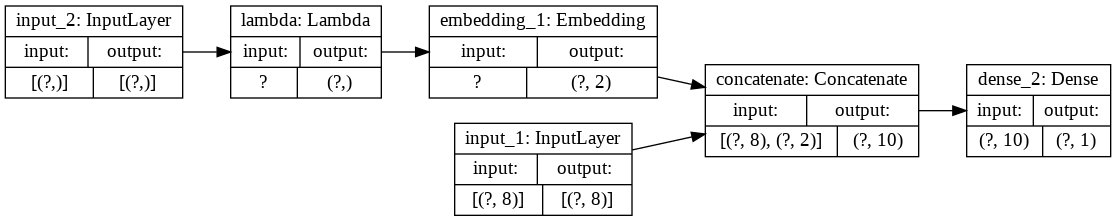

In [70]:
tf.keras.utils.plot_model(
    model, 
    show_shapes=True,
    show_layer_names=True,
    rankdir="LR"
)

This model takes two inputs: a regular input containing eight numerical features per instance, plus a categorical input (containing one categorical feature per instance). It uses a Lambda layer to look up each category’s index, then it looks up the embeddings for these indices. Next, it concatenates the embeddings and the regular inputs in order to give the encoded inputs, which are ready to be fed to a neural network. We could add any kind of neural network at this point, but we just add a dense output layer, and we create the Keras model.

## TF Transform
TensorFlow eXtended (TFX) an end-toend platform for productionizing TensorFlow models. First, to use a TFX component such as TF Transform, you must install it; it does not come bundled with TensorFlow. You then define your preprocessing function just once (in Python), by using TF Transform functions for scaling, bucketizing, and more. You can also use any TensorFlow operation you need. Here is what this preprocessing function might look like if we just had two features:

In [73]:
import tensorflow_transform as tft

def preprocess(inputs):  # inputs is a batch of input features
    median_age = inputs["housing_median_age"]
    ocean_proximity = inputs["ocean_proximity"]
    standardized_age = tft.scale_to_z_score(median_age - tft.mean(median_age))
    ocean_proximity_id = tft.compute_and_apply_vocabulary(ocean_proximity)
    return {
        "standardized_median_age": standardized_age,
        "ocean_proximity_id": ocean_proximity_id
    }

Next, TF Transform lets you apply this preprocess() function to the whole training set using Apache Beam (it provides an AnalyzeAndTransformDataset class that you can use for this purpose in your Apache Beam pipeline). In the process, it will also compute all the necessary statistics over the whole training set: in this example, the mean and standard deviation of the housing_median_age feature, and the vocabulary for the ocean_proximity feature. The components that compute these statistics are called analyzers.

Importantly, TF Transform will also generate an equivalent TensorFlow Function that you can plug into the model you deploy. This TF Function includes some constants that correspond to all the all the necessary statistics computed by Apache Beam (the mean, standard deviation, and vocabulary).

With the Data API, TFRecords, the Keras preprocessing layers, and TF Transform, you can build highly scalable input pipelines for training and benefit from fast and portable data preprocessing in production.

But what if you just wanted to use a standard dataset? Well in that case, things are much simpler: just use TFDS!


## TF Datasets (TFDS)
The TensorFlow Datasets project makes it very easy to download common datasets, from small ones like MNIST or Fashion MNIST to huge datasets like ImageNet. The list includes image datasets, text datasets (including translation datasets), and audio and video datasets. You can visit https:// homl.info/tfds to view the full list, along with a description of each dataset.

TFDS is not bundled with TensorFlow, so you need to install the tensorflowdatasets library (e.g., using pip). Then call the tfds.load() function, and it will download the data you want (unless it was already downloaded earlier) and return the data as a dictionary of datasets (typically one for training and one for testing, but this depends on the dataset you choose). For example, let’s download MNIST:

In [74]:
import tensorflow_datasets as tfds

datasets = tfds.load(name="mnist")
mnist_train, mnist_test = datasets["train"], datasets["test"]

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.0. Subsequent calls will reuse this data.


Note that each item in the dataset is a dictionary containing both the features and the labels. But Keras expects each item to be a tuple containing two elements (again, the features and the labels). You could transform the dataset using the map() method, like this:

In [75]:
mnist_train = mnist_train.shuffle(10000).batch(32)
mnist_train = mnist_train.map(lambda items: (items["image"], items["label"]))
mnist_train = mnist_train.prefetch(1)

In [81]:
for ele in mnist_train.take(1):
    print(ele[0].shape, ele[1].shape)

(32, 28, 28, 1) (32,)


But it’s simpler to ask the load() function to do this for you by setting as_super vised=True (obviously this works only for labeled datasets). You can also specify the batch size if you want. Then you can pass the dataset directly to your tf.keras model:

In [82]:
dataset = tfds.load(name="mnist", batch_size=32, as_supervised=True)
mnist_train = dataset["train"].prefetch(1)
# model = keras.models.Sequential([...])
# model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd")
# model.fit(mnist_train, epochs=5)